In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from collections import defaultdict
import imaplib
import email
from email.header import decode_header
import os
from dotenv import load_dotenv
import re
from bs4 import BeautifulSoup
from imbox import Imbox
import imaplib
import io
from PIL import Image
import matplotlib.pyplot as plt
from parsers.maxima_parser import maxima_parser

from pdf2image import convert_from_bytes

imaplib.IMAP4._encoding = 'utf-8'

In [3]:
# Initialize connection
load_dotenv()
imap_server = os.getenv("IMAP_SERVER")
email_address = os.getenv("EMAIL_ADDRESS")
password = os.getenv("EMAIL_PASSWORD")

mail = Imbox(imap_server, username=email_address, password=password, ssl=True, ssl_context=None, starttls=False)

In [4]:
filters = [
    {"sender": "noreply.tsekk@maxima.ee", "subject": "Sinu ostutšekk!"},
    {"sender": "noreply@rimibaltic.com", "subject": "Sinu ostutšekk"},
    {"sender": "estonia-food@bolt.eu", "subject": "Delivery from Bolt Food"}
]

### Parse Maxima

In [5]:
filter_criteria = filters[0] # maxima

filter_sender = filter_criteria["sender"]
filter_subject = filter_criteria["subject"]

messages = mail.messages(sent_from=filter_sender)

In [13]:
parsed_receipts = []

for uid, message in messages:
    if message.subject == filter_subject:
        sent_from = message.sent_from
        sent_to = message.sent_to
        subject = message.subject
        headers = message.headers
        message_id = message.message_id
        date = message.date
        body = message.body
        attachments = message.attachments

        results = maxima_parser(body['html'][0])
        parsed_receipts.append(results)

Total Spent: 183.68 €
Total Discounts: nan €
Most Frequently Purchased Product: Kohuke MAGIJA
Total Spending Per Day:
dtime
2024-05-27     9.73
2024-05-30    18.88
2024-06-01     5.28
2024-06-02    17.73
2024-06-03    19.38
2024-06-05    21.12
2024-06-07    16.89
2024-06-09    27.54
2024-06-10     7.57
2024-06-11     8.22
2024-06-12    13.95
2024-06-19    15.62
2024-06-20    15.58
2024-06-21    16.55
2024-06-26    12.69
2024-06-29    11.42
Name: price, dtype: float64
Total Spending Per Month:
dtime
2024-05     28.61
2024-06    209.54
Freq: M, Name: price, dtype: float64
Total Spending Per Store:
Võru 55, Tartu        122.33
Turu tn. 14, Tartu     61.35
dtype: float64
Average Spending Per Store: 91.84 €


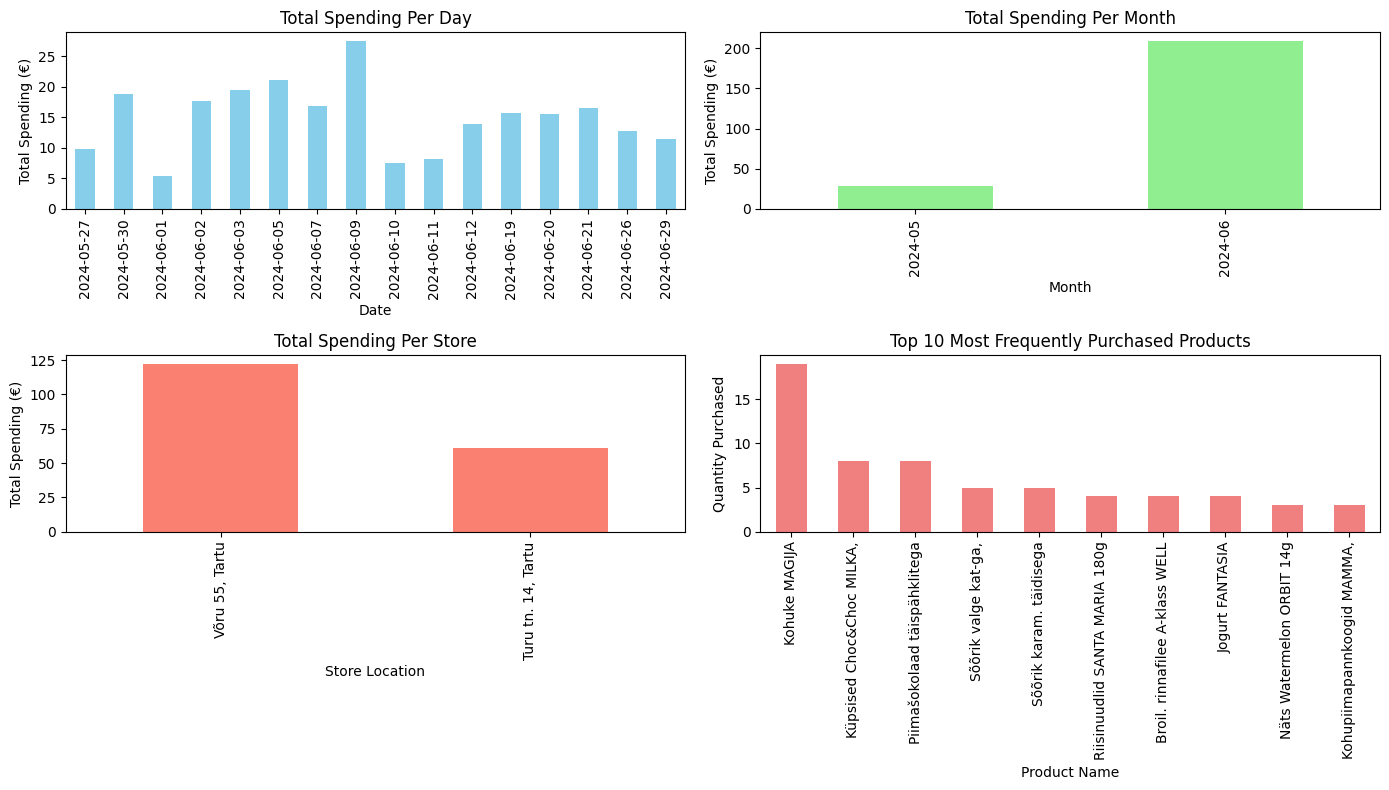

(           location               dtime                    product_name  \
 0    Võru 55, Tartu 2024-05-27 21:58:02       Küpsised Choc&Choc MILKA,   
 1    Võru 55, Tartu 2024-05-27 21:58:02    Piimašokolaad täispähklitega   
 2    Võru 55, Tartu 2024-05-27 21:58:02    Suur kilekott MAXIMA 38x64cm   
 3    Võru 55, Tartu 2024-05-30 11:01:00  Broil. rinnafilee A-klass WELL   
 4    Võru 55, Tartu 2024-05-30 11:01:00                   Kohuke MAGIJA   
 ..              ...                 ...                             ...   
 122  Võru 55, Tartu 2024-06-29 14:59:32      Küpsised Choco Minis MILKA   
 123  Võru 55, Tartu 2024-06-29 14:59:32       Broil. rinnafilee palad A   
 124  Võru 55, Tartu 2024-06-29 14:59:32              Sõõrik valge kat.,   
 125  Võru 55, Tartu 2024-06-29 14:59:32                 Jogurt FANTASIA   
 126  Võru 55, Tartu 2024-06-29 14:59:32    Kompvekikarp Toffifee STORCK   
 
      quantity  price  discount  
 0         2.0   5.50      2.32  
 1         2.0   3

In [19]:
import pandas as pd
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt

def analyze_spending(data):
    # Initialize lists and variables to collect all data
    all_purchases = []
    total_spent_per_store = defaultdict(float)
    product_frequency = defaultdict(int)
    total_discounts = 0
    total_spent = 0

    for entry in data:
        location = entry['location']
        total_spent_per_store[location] += entry['total']
        total_spent += entry['total']

        # Parse the date and time
        dtime = datetime.strptime(entry['dtime'], "%d.%m.%Y %H:%M:%S")

        # Process the DataFrame of products directly
        products_df = entry['products']
        
        # Aggregate product data
        for _, product in products_df.iterrows():
            product_name = product['name_products']
            quantity = product['quantity']
            price = product['price']
            discount = product['discount']
            
            # Update product frequency and total discounts
            product_frequency[product_name] += quantity
            total_discounts += discount
            
            # Collect all purchase data
            all_purchases.append({
                'location': location,
                'dtime': dtime,
                'product_name': product_name,
                'quantity': quantity,
                'price': price,
                'discount': discount
            })

    df = pd.DataFrame(all_purchases)

    # Calculate stats
    most_frequent_product = df.groupby('product_name')[['quantity', 'price', 'discount']].sum().sort_values(by='quantity', ascending=False).head(1)
    total_per_day = df.groupby(df['dtime'].dt.date)['price'].sum()
    total_per_month = df.groupby(df['dtime'].dt.to_period('M'))['price'].sum()
    total_per_store = pd.Series(total_spent_per_store).sort_values(ascending=False)
    
    avg_spent_per_store = total_per_store.mean()

    # Stats
    print(f"Total Spent: {total_spent:.2f} €")
    print(f"Total Discounts: {total_discounts:.2f} €")
    print(f"Most Frequently Purchased Product: {most_frequent_product.index[0]}")
    print(f"Total Spending Per Day:\n{total_per_day}")
    print(f"Total Spending Per Month:\n{total_per_month}")
    print(f"Total Spending Per Store:\n{total_per_store}")
    print(f"Average Spending Per Store: {avg_spent_per_store:.2f} €")

    plt.figure(figsize=(14, 8))

    # Plot 1: Total Spending Per Day
    plt.subplot(2, 2, 1)
    total_per_day.plot(kind='bar', color='skyblue')
    plt.title('Total Spending Per Day')
    plt.ylabel('Total Spending (€)')
    plt.xlabel('Date')

    # Plot 2: Total Spending Per Month
    plt.subplot(2, 2, 2)
    total_per_month.plot(kind='bar', color='lightgreen')
    plt.title('Total Spending Per Month')
    plt.ylabel('Total Spending (€)')
    plt.xlabel('Month')

    # Plot 3: Total Spending Per Store
    plt.subplot(2, 2, 3)
    total_per_store.plot(kind='bar', color='salmon')
    plt.title('Total Spending Per Store')
    plt.ylabel('Total Spending (€)')
    plt.xlabel('Store Location')

    # Plot 4: Most Frequently Purchased Products
    top_products = df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)
    plt.subplot(2, 2, 4)
    top_products.plot(kind='bar', color='lightcoral')
    plt.title('Top 10 Most Frequently Purchased Products')
    plt.ylabel('Quantity Purchased')
    plt.xlabel('Product Name')

    plt.tight_layout()
    plt.show()

    return df, total_spent_per_store, product_frequency

analyze_spending(parsed_receipts)


### Parse RIMI

In [13]:
pdf_io = [a for a in attachments if a['content-type'] == 'application/pdf'][0]['content']
pdf_io.getvalue()


# Save PDF to validate
# with open("output.pdf", "wb") as f:
#     f.write(pdf_io.getvalue())

# use ocr
import io
from pdf2image import convert_from_bytes
import pytesseract

images = convert_from_bytes(pdf_io.getvalue())

text = ""
for image in images:
    text += pytesseract.image_to_string(image)

print(text)

b'%PDF-1.4\n%\xe2\xe3\xcf\xd3\n1 0 obj\n<</Type/XObject/Subtype/Image/Width 346/Height 864/Filter/DCTDecode/ColorSpace/DeviceRGB/BitsPerComponent 8/Length 88705>>stream\n\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x03`\x01Z\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x8

Old code

In [18]:
num = message_numbers[0].split()[1]

_, msg_data = imap_connection.fetch(num, '(RFC822)')
email_body = msg_data[0][1]
email_message = email.message_from_bytes(email_body)

email_subject, encoding = decode_header(email_message["Subject"])[0]

if isinstance(email_subject, bytes):
    email_subject = email_subject.decode(encoding or "utf-8")

if email_subject == subject:
    email_sender = email_message["From"]
    email_date = email_message["Date"]
    
    content = get_email_content(email_message)
    
    filtered_emails[sender].append({
        "subject": email_subject,
        "sender": email_sender,
        "date": email_date,
        "content": content
    })

multipart/mixed
multipart/related


AttributeError: 'NoneType' object has no attribute 'decode'

In [12]:
content

'<html>\r\n\r\n<head>\r\n    <meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />\r\n</head>\r\n\r\n<table style="width:100%;font-family:Arial,sans-serif;font-weight:normal;line-height:0">\r\n    <tbody>\r\n    <tr>\r\n        <td style="background-color:white" align="center" valign="top">\r\n<table style="margin:0;padding:0;width:700px;line-height:normal" cellspacing="0" cellpadding="0" border="0" width="700">\r\n    <tbody><tr>\r\n        <td style="line-height:0;padding:60px 0 0 0;line-height:0" valign="top">\r\n            <img src="cid:bgImage" style="max-width:100%;line-height:0">\r\n        </td>\r\n    </tr>\r\n     </tbody>\r\n</table>\r\n\r\n<table style="margin:0;padding:0;width:770px" width="700" cellspacing="0" cellpadding="0" border="0">\r\n    <tbody>\r\n    <tr>\r\n        <td  style="background-color:white;padding:20px 0px 0 60px">\r\n             <h2 style="color:#363d40;font-size:24px;line-height:28px">Hea klient,</h2>\r\n             <br>\r\n       

In [ ]:
imap_connection.logout()